# EuroSAT images classification
The [EuroSAT RGB](https://github.com/phelber/EuroSAT) dataset contains 27000 patches of Sentinel-2 64x64 pixels RGB images divided in 10 classes: Pasture, HerbaceousVegetation, Industrial, AnnualCrop, Residential, PermanentCrop, Highway, SeaLake, Forest, River. 

In [2]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import warnings
import torch
import torch.nn as nn
import torchvision
warnings.filterwarnings('ignore')
print("NumPy version: %s"%np.__version__)
print("Pandas version: %s"%pd.__version__)
print("PyTorch version: %s"%torch.__version__)

NumPy version: 1.23.1
Pandas version: 1.4.3
PyTorch version: 1.13.0


We download the dataset into a local folder in order to create a training set, a validation set, and a test set. For each class we will use 70% of the images for training, 20% for validation, and 10% for test. we can see that each class contains 2500 or 3000 images so the classes are quite well balanced. 

In [3]:
import os
import pathlib

imgdir_path = pathlib.Path('../../eurosatprj/data/EuroSAT/2750')
tot = 0
file_list = []
for folder_path in imgdir_path.glob('*'):
    print(f'{folder_path}')
    count = 0
    for file_path in folder_path.glob('*'): 
        #file_name = file_path.relative_to(folder_path)
        file_list.append(str(file_path))
        count += 1
    print(count)
    tot += count
print('Total number of files: {0:d}'.format(tot))

..\..\eurosatprj\data\EuroSAT\2750\AnnualCrop
3000
..\..\eurosatprj\data\EuroSAT\2750\Forest
3000
..\..\eurosatprj\data\EuroSAT\2750\HerbaceousVegetation
3000
..\..\eurosatprj\data\EuroSAT\2750\Highway
2500
..\..\eurosatprj\data\EuroSAT\2750\Industrial
2500
..\..\eurosatprj\data\EuroSAT\2750\Pasture
2000
..\..\eurosatprj\data\EuroSAT\2750\PermanentCrop
2500
..\..\eurosatprj\data\EuroSAT\2750\Residential
3000
..\..\eurosatprj\data\EuroSAT\2750\River
2500
..\..\eurosatprj\data\EuroSAT\2750\SeaLake
3000
Total number of files: 27000


We put the file paths and the labels into two lists that will be passed to our dataset class

In [4]:
import re

file_names = [str(os.path.basename(path)) for path in file_list]
reg_ex = r'(.+)_\d+.jpg$'
labels = [re.findall(reg_ex, file_name)[0] for file_name in file_names]
eurosat_classes = np.unique(labels).tolist()
num_labels = [eurosat_classes.index(label) for label in labels]

In [5]:
file_list[6001], labels[6001], num_labels[6001]

('..\\..\\eurosatprj\\data\\EuroSAT\\2750\\HerbaceousVegetation\\HerbaceousVegetation_10.jpg',
 'HerbaceousVegetation',
 2)

We want to be able to shuffle the files with their labels. We put them together using the zip() function so that the index for the image and its label will stay the same after the shuffle. 

In [7]:
file_list_labels = list(zip(file_list, labels))
np.random.shuffle(file_list_labels)

After the shuffle we split the file paths and the labels again so we will be able to pass them to instantiate a PyTorch Dataset.

In [8]:
files, labels = zip(*file_list_labels) # unzip randomized file paths and labels

In [9]:
files[100], labels[100]

('..\\..\\eurosatprj\\data\\EuroSAT\\2750\\Pasture\\Pasture_270.jpg',
 'Pasture')

We can have a look at some of the images

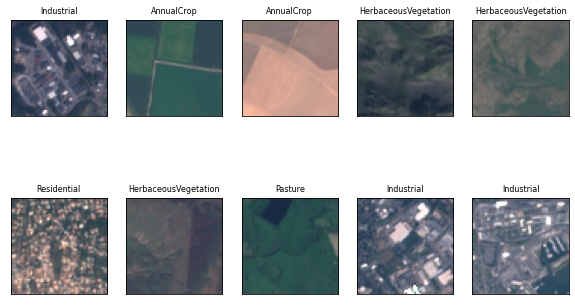

In [10]:
from itertools import islice
from PIL import Image

fig = plt.figure(figsize=(10, 6))
start = 3000
stop = 3010
for i, (image, label) in islice(enumerate(file_list_labels), start, stop):
    ax = fig.add_subplot(2, 5, i - start + 1)
    ax.set_xticks([]); ax.set_yticks([])
    ax.set_title(f'{label}', size=8)
    img = Image.open(image)
    ax.imshow(img)
    


## The EuroSatDataset class
We implement the data structure for the EuroSAT dataset as a subclass of PyTorch Dataset, where we store the paths to the images on the file system and their labels.

In [11]:
from torch.utils.data import Dataset
from torchvision.io import read_image
import re

class EuroSatDataset(Dataset):
    def __init__(self, file_list, labels, transform=None, target_transform=None):
        self.labels = labels
        self.file_list = file_list
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        image = read_image(self.file_list[index])      
        label = self.labels[index]
        if self.transform:
            image = self.transform(image)
        
        return image, label

we create an instance of our dataset passing the file paths and the labels

In [12]:
eurosat_dataset = EuroSatDataset(files, labels)

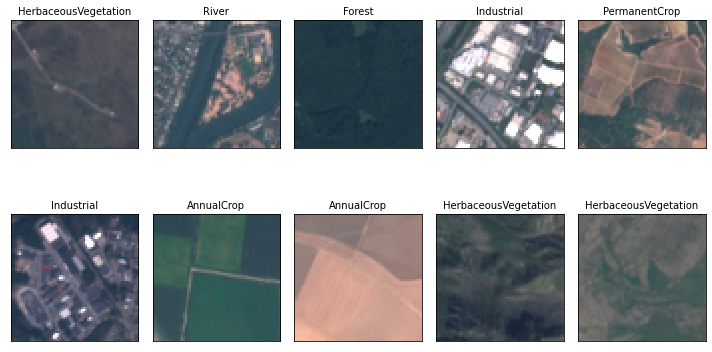

In [13]:
start = 2995
stop = 3005
fig = plt.figure(figsize=(10, 6))
for i, example in islice(enumerate(eurosat_dataset), start, stop):
    ax = fig.add_subplot(2, 5, i - start + 1)
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(example[0].numpy().transpose((1, 2, 0)))
    ax.set_title(f'{example[1]}', size=10)
    
plt.tight_layout()
plt.show()

## The EuroSAT DataLoader
Once we have implemented the dataset to store the paths to the images and the labels, we have to carry out the following steps:  
 
1. Split them into three subsets for training, validation, and test
2. Define the batches that will be used for training our model 

In PyTorch we can use the random_split() function to randomize and split the data. In our case the data has been already randomized. 

In [14]:
from torch.utils.data import random_split

euro_train_ds, euro_val_ds, euro_test_ds = random_split(eurosat_dataset, [0.7, 0.2, 0.1], 
                                                        generator=torch.Generator().manual_seed(42))

The sum of the images in the three subsets is the same as in the original dataset.

In [15]:
len(euro_train_ds) + len(euro_val_ds) + len(euro_test_ds) 

27000

We can perform a visual check to see that there's no mismatch between images and labels

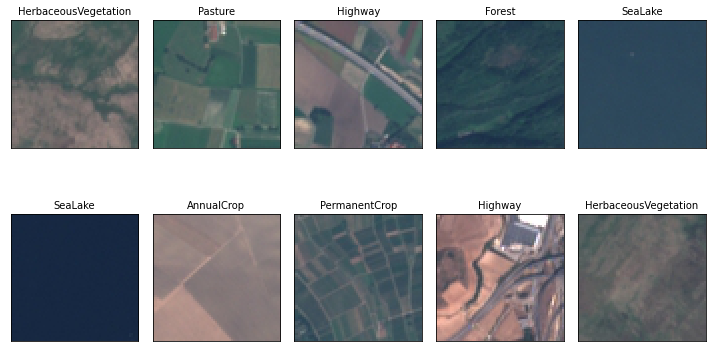

In [16]:
fig = plt.figure(figsize=(10, 6))
for i, example in enumerate(euro_train_ds):
    if i >= 10: break
    ax = fig.add_subplot(2, 5, i + 1)
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(example[0].numpy().transpose((1, 2, 0)))
    ax.set_title(f'{example[1]}', size=10)
    
plt.tight_layout()
plt.show()

We can now create the Dataloaders for our three subsets

In [17]:
from torch.utils.data import DataLoader

torch.manual_seed(1)
eurosat_train_dl = DataLoader(dataset=euro_train_ds, batch_size=64, shuffle=False)
eurosat_val_dl = DataLoader(dataset=euro_val_ds, batch_size=64, shuffle=False)
eurosat_test_dl = DataLoader(dataset=euro_test_ds, batch_size=64, shuffle=False)

## Data augmentation
We can increase the size of our dataset by applying some affine transformations (translation, scaling, rotation, flipping) and other transformations such as cropping or changing the brightness or the contrast.  

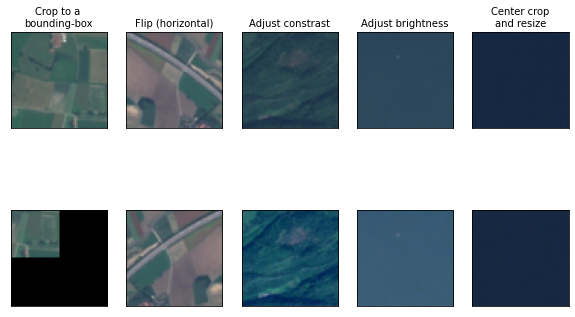

In [18]:
from torchvision import transforms 

fig = plt.figure(figsize=(10, 6))

## Column 1: cropping to a bounding-box
ax = fig.add_subplot(2, 5, 1)
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])
img, attr = euro_train_ds[1]
ax.set_title('Crop to a \nbounding-box', size=10)
ax.imshow(img.numpy().transpose((1, 2, 0)))
ax = fig.add_subplot(2, 5, 6)
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])
img_cropped = transforms.functional.crop(img, 32, 32, 64, 64)
ax.imshow(img_cropped.numpy().transpose((1, 2, 0)))


## Column 2: flipping (horizontally)
ax = fig.add_subplot(2, 5, 2)
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])
img, attr = euro_train_ds[2]
ax.set_title('Flip (horizontal)', size=10)
ax.imshow(img.numpy().transpose((1, 2, 0)))
ax = fig.add_subplot(2, 5, 7)
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])
img_flipped = transforms.functional.hflip(img)
ax.imshow(img_flipped.numpy().transpose((1, 2, 0)))

## Column 3: adjust contrast
ax = fig.add_subplot(2, 5, 3)
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])
img, attr = euro_train_ds[3]
ax.set_title('Adjust constrast', size=10)
ax.imshow(img.numpy().transpose((1, 2, 0)))
ax = fig.add_subplot(2, 5, 8)
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])
img_adj_contrast = transforms.functional.adjust_contrast(img, contrast_factor=2)
ax.imshow(img_adj_contrast.numpy().transpose((1, 2, 0)))

## Column 4: adjust brightness
ax = fig.add_subplot(2, 5, 4)
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])
img, attr = euro_train_ds[4]
ax.set_title('Adjust brightness', size=10)
ax.imshow(img.numpy().transpose((1, 2, 0)))
ax = fig.add_subplot(2, 5, 9)
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])
img_adj_brightness = transforms.functional.adjust_brightness(img, brightness_factor=1.3)
ax.imshow(img_adj_brightness.numpy().transpose((1, 2, 0)))

## Column 5: cropping from image center 
ax = fig.add_subplot(2, 5, 5)
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])
img, attr = euro_train_ds[5]
ax.set_title('Center crop\nand resize', size=10)
ax.imshow(img.numpy().transpose((1, 2, 0)))
ax = fig.add_subplot(2, 5, 10)
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])
img_center_crop = transforms.functional.center_crop(img, [32, 32])
img_resized = transforms.functional.resize(img_center_crop, size=(64, 64))
ax.imshow(img_resized.numpy().transpose((1, 2, 0)))

We can apply the transformations randomly and one after the other in a pipeline

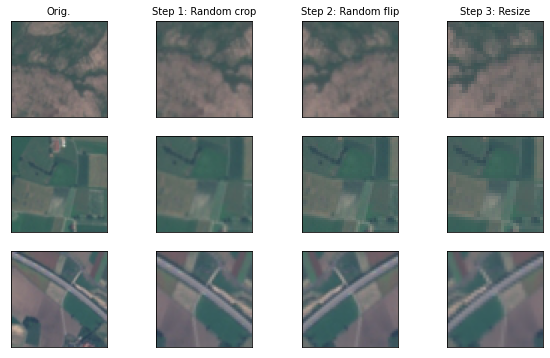

In [20]:
torch.manual_seed(123)

fig = plt.figure(figsize=(10, 6))

for i, (img, attr) in enumerate(euro_train_ds):
    ax = fig.add_subplot(3, 4, i*4+1)
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    ax.imshow(img.numpy().transpose((1, 2, 0)))
    if i == 0:
        ax.set_title('Orig.', size=10)
    ax = fig.add_subplot(3, 4, i*4+2)
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    img_transform = transforms.Compose([transforms.RandomCrop([48, 48])])
    img_cropped = img_transform(img)
    ax.imshow(img_cropped.numpy().transpose((1, 2, 0)))
    
    if i == 0:
        ax.set_title('Step 1: Random crop', size=10)
    ax = fig.add_subplot(3, 4, i*4+3)
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    img_transform = transforms.Compose([transforms.RandomHorizontalFlip()])
    img_flip = img_transform(img_cropped)
    ax.imshow(img_flip.numpy().transpose((1, 2, 0)))
    
    if i == 0:
        ax.set_title('Step 2: Random flip', size=10)
    ax = fig.add_subplot(3, 4, i*4+4)
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    img_resized = transforms.functional.resize(img_flip, size=(32, 32))
    ax.imshow(img_resized.numpy().transpose((1, 2, 0)))
    
    if i == 0:
        ax.set_title('Step 3: Resize', size=10)
    if i == 2:
        break

We can collect the set of transformation we want to apply on the images in one function. We use one transformation for the training set to augment the size of the data, and another transformation for the validation and test set to only transform the images into PyTorch tensors. 

In [47]:
transform_train = transforms.Compose([
    transforms.RandomCrop([48, 48]),
    transforms.RandomHorizontalFlip(),
    transforms.Resize([64, 64]),
    #transforms.ToTensor(),
])

transform = transforms.Compose([
    #transforms.ToTensor(),
])

We use the first 70% of the data for training. We compute the number of files with labels that we will use. 

In [24]:
train_set_size = int(0.7 * len(files))
train_set_size

18900

We create a new instance of our dataset using the training set to which we apply the set of transformations we have defined.

In [25]:
euro_train_ds = EuroSatDataset(files[:train_set_size], labels[:train_set_size], transform=transform_train)
len(euro_train_ds)

18900

We create a dataset for validation using 20% of the data

In [28]:
val_set_size = int(0.2 * len(files))
val_set_size

5400

In [48]:
start = train_set_size
stop = train_set_size + val_set_size
euro_val_ds = EuroSatDataset(files[start:stop], labels[start:stop], transform=transform)
len(euro_val_ds)

5400

Finally we create the dataset for test using the remaining files

In [49]:
euro_test_ds = EuroSatDataset(files[stop:], labels[stop:], transform=transform)
len(euro_test_ds)

2700

In [50]:
len(euro_train_ds) + len(euro_val_ds) + len(euro_test_ds)

27000

With the datsets we can create the dataloaders that will be used to train, validate, and test our model

In [51]:
euro_train_dl = DataLoader(euro_train_ds, batch_size=64)
len(euro_train_dl)

296

In [52]:
euro_val_dl = DataLoader(euro_val_ds, batch_size=64)
len(euro_val_dl)

85

In [53]:
euro_test_dl = DataLoader(euro_test_ds, batch_size=64)
len(euro_test_dl)

43

We can see that for the training set there are images that are the result of the transformations we have applied.

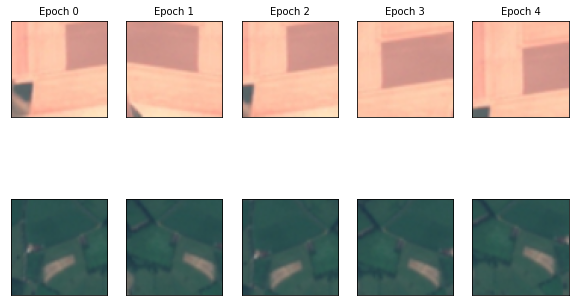

In [56]:
fig = plt.figure(figsize=(10, 6))

num_epochs = 5
for j in range(num_epochs):
    img_batch, label_batch = next(iter(euro_train_dl))
    img = img_batch[0]
    ax = fig.add_subplot(2, 5, j + 1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f'Epoch {j}', size=10)
    ax.imshow(img.permute(1, 2, 0))

    img = img_batch[1]
    ax = fig.add_subplot(2, 5, j + 6)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(img.permute(1, 2, 0))

## The LULC classifier
We define a convolutional neural network for LULC classification using the dataloaders that we have built. The size of the input RGB images is 3x64x64. The network contains four convolutional layers that will extract the feature maps to be used to compute the pobability of an image to belong to any of the 10 classes that have been defined for the EuroSAT dataset.
The convolutional layers use a padding of 1 and stride 1 so the height and width of the output is the same as the input. The max pooling layer with a 2x2 kernel reduces height and width by half. The size of the output tensors for each layer are as follow

1. Layer 1:
    1. Input: 3x64x64
    2. Conv1: 32x64x64
    3. MaxPool1: 32x32x32

2. Layer 2:
    1. Conv2: 64x32x32
    2. MaxPool2: 64x16x16

3. Layer 3:
    1. Conv3: 128x16x16
    2. MaxPool3: 128x8x8

4. Layer 4:
    1. Conv4: 256x8x8

5. Layer 5:
    1. AvePool2: 256x1
    2. Flatten: 256

6. Layer 6:
    1. FullyConnected: 10

    
![EuroSAT CNN Architecture](images/eurosat_cnn.jpg)

In [61]:
import torch.nn as nn

model = nn.Sequential()

model.add_module('conv1', nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1))
model.add_module('relu1', nn.ReLU())        
model.add_module('pool1', nn.MaxPool2d(kernel_size=2))  
model.add_module('dropout1', nn.Dropout(p=0.5)) 

model.add_module('conv2', nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1))
model.add_module('relu2', nn.ReLU())        
model.add_module('pool2', nn.MaxPool2d(kernel_size=2))   
model.add_module('dropout2', nn.Dropout(p=0.5)) 

model.add_module('conv3', nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1))
model.add_module('relu3', nn.ReLU())        
model.add_module('pool3', nn.MaxPool2d(kernel_size=2))   

model.add_module('conv4', nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1))
model.add_module('relu4', nn.ReLU())

model.add_module('pool4', nn.AvgPool2d(kernel_size=8)) 
model.add_module('flatten', nn.Flatten()) 

model.add_module('fc', nn.Linear(256, 10)) 

In [63]:
x = torch.ones((4, 3, 64, 64))
model(x).shape

torch.Size([4, 10])